In [6]:
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import seaborn as sns

### This is a tutorial for demonstrating optimization across trains and/or unit processes. This demo is specific for the BOR RO model and selects the least cost system for a given flow. The steps are:
#### 1. Load membrane option table.
#### 2. Load individual trains, each with a different membrane, and save the results.
#### 3. Check results and see which train is least cost (to be check vs. optimzied solution in step 6).
#### 4. Load train that contains all train options.
#### 5. Run model to select least cost.
#### 6. Check results


##### Import WaterTAP3 Package

In [7]:
import watertap as wt

##### Step 1: Load membrane option table.

In [8]:
membrane_option_table = pd.read_csv('data/membrane_options.csv')
membrane_option_table.head()

,characteristic,unit,value,manufacturer,model,process_type,reference
0,mem_diameter,cm,20.32,FilmTec,BW30-400,RO,BOR_WaTER
1,mem_productivity,m3/day,40.00,FilmTec,BW30-400,RO,BOR_WaTER
2,mem_area_per_module,m2,37.00,FilmTec,BW30-400,RO,BOR_WaTER
3,mem_operating_pressure,kPa,1550.00,FilmTec,BW30-400,RO,BOR_WaTER
4,mem_TDS,mg/L,2000.00,FilmTec,BW30-400,RO,BOR_WaTER


##### Step 2: Load individual trains, run each model, and save results in a table.

In [9]:
# set up empty table that results will be saved to
final_results = pd.DataFrame()

# directory name for treatment trains
directory_name = 'trains/bor_trains'                          
directory = os.fsencode(directory_name)

# loop through each individual train, build and run model, save results.
for file in os.listdir(directory):    
    filename = os.fsdecode(file)
    path = ('%s/%s' % (directory_name, filename))
    T = wt.load_train(path)
    
    # set inflow
    T.nodes['source']['Flow'] = 5000
    
    # build and run model
    M = wt.build_model(T)
    model_solution = wt.run_model(model=M)
    
    # get results and save in a table -> 'final_results'
    analysis_variables = ['Flow', 'Cost']
    model_results = wt.post_processing.get_result_table(M, analysis_variables)
    model_results['membrane_scenario'] = np.array(filename[4:-4])
    final_results = pd.concat([final_results, model_results])

Membrane: DuPont --- 6880T B-10 Twin
Membrane: FilmTec --- BW30-400
Membrane: FilmTec --- SW30-8040
Membrane: Hydranautics --- 8040LHYCPA2
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)


In [10]:
final_results.tail()

,Flow,Cost,membrane_scenario
chlorination_twb_use_stream,4037.5,0.000,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"
microfiltration_twb_feedwater,5000.0,0.000,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"
microfiltration_twb,5000.0,3.141,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"
microfiltration_twb_waste_stream,250.0,0.000,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"
microfiltration_twb_use_stream,4750.0,0.000,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"



##### 3. Check results and see which train is least cost (to be check vs. optimzied solution in step 6).

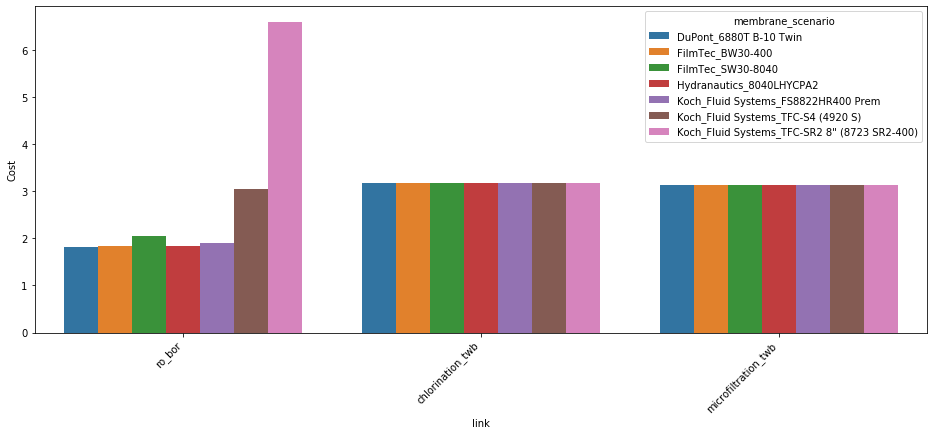

In [11]:
bar_chart = wt.post_processing.get_bar_chart(data = final_results, y_variable = 'Cost', 
                                      compare_scenario = 'membrane_scenario')

In [12]:
final_results[final_results.Cost != 0].loc['ro_bor']

,Flow,Cost,membrane_scenario
ro_bor,4750.0,1.826,DuPont_6880T B-10 Twin
ro_bor,4750.0,1.845,FilmTec_BW30-400
ro_bor,4750.0,2.044,FilmTec_SW30-8040
ro_bor,4750.0,1.840,Hydranautics_8040LHYCPA2
ro_bor,4750.0,1.899,Koch_Fluid Systems_FS8822HR400 Prem
ro_bor,4750.0,3.047,Koch_Fluid Systems_TFC-S4 (4920 S)
ro_bor,4750.0,6.590,"Koch_Fluid Systems_TFC-SR2 8"" (8723 SR2-400)"



##### 4. Load train that contains all train options.

In [13]:
#### LOAD TRAIN ####
path = 'trains/Tutorial3_optimization_treatment_train_bor_example.csv'
T = wt.load_train(path)
wt.display.show_train(T)

In [14]:
T.nodes['source']['Flow'] = 5000 # sets flow. units in m3/d. 37854.118 m3/d = 10 million gallons per day 

##### 5. Run model to select least cost.

In [15]:
M = wt.build_model(T) 
results = wt.run_model(model = M) # choice of objective

Membrane: FilmTec --- BW30-400
Membrane: FilmTec --- SW30-8040
Membrane: Hydranautics --- 8040LHYCPA2
Membrane: Koch_Fluid Systems --- FS8822HR400 Prem
Membrane: Koch_Fluid Systems --- TFC-S4 (4920 S)
Membrane: Koch_Fluid Systems --- TFC-SR2 8" (8723 SR2-400)
Membrane: DuPont --- 6880T B-10 Twin


##### Step 5: Check results

In [16]:
analysis_variables = ['Flow', 'Cost']

In [17]:
model_results = wt.post_processing.get_optimization_result_table(T, M, analysis_variables, ro_membrane = True)

In [18]:
model_results

,Flow,Cost,mem_manu,mem_model_type
ro_bor7_feedwater,4750.0,0.000,None,None
ro_bor7,4750.0,1.826,DuPont,6880T B-10 Twin
ro_bor7_waste_stream,712.5,0.000,None,None
ro_bor7_use_stream,4037.5,0.000,None,None
chlorination_twb_feedwater,4037.5,0.000,None,None
chlorination_twb,4037.5,3.171,None,None
chlorination_twb_use_stream,4037.5,0.000,None,None
microfiltration_twb_feedwater,5000.0,0.000,None,None
microfiltration_twb,5000.0,3.141,None,None
microfiltration_twb_waste_stream,250.0,0.000,None,None
